In [23]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# Feature
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors

# Modeling
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten, Dropout, Conv1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Membaca data
train_data = pd.read_csv('../../Data/5. Split/train_data.csv')
test_data = pd.read_csv('../../Data/5. Split/test_data.csv')

In [25]:
# Memisahkan fitur dan label untuk setiap bagian dataset
x_train = train_data.text_manual_replaced
y_train = train_data.label

x_test = test_data.text_manual_replaced
y_test = test_data.label

Word2Vec

In [26]:
# Memuat model Word2Vec CBOW yang telah disimpan
model_ug_cbow = KeyedVectors.load('./../../Model/w2v_model_ug_cbow.word2vec')

# Memuat model Word2Vec Skip-gram yang telah disimpan
model_ug_sg = KeyedVectors.load('./../../Model/w2v_model_ug_sg.word2vec')

In [27]:
# Menghitung jumlah kata unik dalam model Word2Vec CBOW
unique_words_count = len(model_ug_cbow.wv.index_to_key)

# Menampilkan jumlah kata unik
print(unique_words_count)

7350


In [28]:
embeddings_index = {}

# Menggabungkan kedua embeddings dari model CBOW dan Skip-gram untuk setiap kata unik
for w in model_ug_cbow.wv.index_to_key:
    embeddings_index[w] = np.append(model_ug_cbow.wv[w], model_ug_sg.wv[w])

# Menampilkan jumlah vektor kata yang ditemukan
print('Found %s word vectors.' % len(embeddings_index))

Found 7350 word vectors.


In [29]:
# Membuat tokenizer dengan jumlah kata maksimum 20.000
tokenizer = Tokenizer(num_words=1500)  # num_words adalah jumlah kosakata yang ingin digunakan

# Melatih tokenizer pada teks dari data latih
tokenizer.fit_on_texts(x_train)

# Mengonversi teks menjadi urutan bilangan bulat yang merepresentasikan indeks kata
sequences = tokenizer.texts_to_sequences(x_train)

In [30]:
# Menghitung jumlah kata unik dalam tokenizer
unique_token_count = len(tokenizer.word_index)

# Menampilkan jumlah kata unik
print(unique_token_count)

6053


In [31]:
# Menampilkan 5 teks pertama dari data latih (x_train)
for x in x_train[:5]:
    print(x)

bagus pak dokter
kok sekarang baru tahu lalu apa tugas bpom
betul dokter minum kemas lebih bahaya
jajan minum banyak jual warung warung perlu teliti kandung zat apa saj yang masuk hewan tidak suka lalau kasih anak anak konsumsi dong komisi lindung anak bantu masyarakat selidik jajan anak bangsa
suara dokter richard itu khas banget biarpun wajah enggak lihat suara kenal orang sudah jadi selebriti repot privasi jadi kurang semangat sukses terus iya dok buat edukasi masyarakat


In [32]:
# Menampilkan urutan indeks kata dari teks pertama dalam data latih (sequences)
print(sequences[:1])

[[191, 136, 7]]


In [33]:
length = []

# Menghitung jumlah kata dalam setiap teks dari data latih (x_train) dan menyimpannya dalam daftar length
for x in x_train:
    length.append(len(x.split()))

# length berisi panjang (jumlah kata) dari setiap teks dalam data latih

In [34]:
# Menghitung jumlah kata maksimum dalam satu kalimat dari data latih (x_train)
max_word_count = max(length)

# Menampilkan jumlah kata maksimum
print("Maximum number of words in a sentence:", max_word_count)

Maximum number of words in a sentence: 399


In [35]:
# Menetapkan panjang maksimum urutan (max_len) untuk padding
max_len = 400

# max_len digunakan untuk membatasi panjang urutan maksimum saat melakukan padding

In [36]:
# Melakukan padding pada urutan data latih (x_train) agar memiliki panjang yang sama (max_len)
x_train_seq = pad_sequences(sequences, maxlen=max_len)

# Menampilkan bentuk tensor data latih yang telah dipad (x_train_seq)
print('Shape of padded data tensor:', x_train_seq.shape)

Shape of padded data tensor: (3582, 400)


In [37]:
# Menampilkan 5 sampel pertama dari data latih yang telah dipad (x_train_seq)
print(x_train_seq[:5])


[[  0   0   0 ... 191 136   7]
 [  0   0   0 ...  10 633  16]
 [  0   0   0 ... 187  36  98]
 [  0   0   0 ... 156   3 555]
 [  0   0   0 ...  29 120  92]]


In [38]:
# Mengonversi teks dalam data test (x_test) menjadi urutan angka menggunakan tokenizer yang sama
sequences_val = tokenizer.texts_to_sequences(x_test)

# Melakukan padding pada urutan data validasi agar memiliki panjang yang sama (max_len)
x_test_seq = pad_sequences(sequences_val, maxlen=max_len)

# Komentar: Sekarang, x_test_seq berisi data validasi yang telah dipad dan siap digunakan

In [39]:
# Menetapkan jumlah kata yang akan digunakan dalam matriks embedding
num_words = len(tokenizer.word_index) + 1

# Membuat matriks embedding kosong dengan bentuk (num_words, 200)
embedding_matrix = np.zeros((num_words, 200))

# Mengisi matriks embedding dengan vektor embedding yang sesuai dari embeddings_index
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Komentar: embedding_matrix sekarang berisi vektor embedding untuk seluruh kata unik dalam tokenizer.word_index

In [40]:
# Memeriksa kesetaraan antara vektor embedding ke-29 dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[29], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding ke-29 sama dengan vektor embedding kata 'baik'? False


In [41]:
# Cari indeks kata 'baik' dalam tokenizer.word_index
baik_index = tokenizer.word_index.get('baik')

# Memeriksa kesetaraan antara vektor embedding kata 'baik' dalam matriks embedding dan vektor embedding kata 'baik' dalam embeddings_index
equal_vectors = np.array_equal(embedding_matrix[baik_index], embeddings_index.get('baik'))

# Cetak hasil kesetaraan vektor
print("Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'?", equal_vectors)

Apakah vektor embedding untuk kata 'baik' di posisi yang benar dalam embedding_matrix sama dengan vektor embedding kata 'baik'? True


In [42]:
# Ubah label menjadi one-hot encoding
y_train_cat = to_categorical(y_train + 1, num_classes=3)
y_test_cat = to_categorical(y_test + 1, num_classes=3)

Pemodelan LSTM

In [43]:
# Membangun model LSTM
model_lstm = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang tidak dapat dilatih
model_lstm.add(Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False))

# Menambahkan lapisan SpatialDropout1D
model_lstm.add(SpatialDropout1D(0.2))

# Menambahkan lapisan LSTM
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

# Menambahkan lapisan Dense dengan fungsi aktivasi ReLU
model_lstm.add(Dense(256, activation='relu'))

# Menambahkan lapisan Dense dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_lstm.add(Dense(3, activation='softmax'))

# Mengkompilasi model LSTM
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menampilkan ringkasan model
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 400, 200)          1210800   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 400, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense_2 (Dense)             (None, 256)               25856     
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 1,357,827
Trainable params: 147,027
Non-trainable params: 1,210,800
______________________________________

In [44]:
# Melatih model dengan data latih dan validasi (gunakan y_train_cat dan y_test_cat untuk label one-hot encoded)
model_lstm.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
112/112 - 119s - loss: 0.9578 - accuracy: 0.5516 - val_loss: 0.8753 - val_accuracy: 0.6114 - 119s/epoch - 1s/step
Epoch 2/5
112/112 - 124s - loss: 0.8298 - accuracy: 0.6357 - val_loss: 0.8437 - val_accuracy: 0.6340 - 124s/epoch - 1s/step
Epoch 3/5
112/112 - 102s - loss: 0.7767 - accuracy: 0.6731 - val_loss: 0.8231 - val_accuracy: 0.6466 - 102s/epoch - 912ms/step
Epoch 4/5
112/112 - 85s - loss: 0.7161 - accuracy: 0.6974 - val_loss: 0.8397 - val_accuracy: 0.6516 - 85s/epoch - 755ms/step
Epoch 5/5
112/112 - 103s - loss: 0.6856 - accuracy: 0.7085 - val_loss: 0.8279 - val_accuracy: 0.6541 - 103s/epoch - 920ms/step


In [45]:
# Membangun model LSTM
model_lstm_02 = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang tidak dapat dilatih
model_lstm_02.add(Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False))

# Menambahkan lapisan SpatialDropout1D
model_lstm_02.add(SpatialDropout1D(0.5))

# Menambahkan lapisan LSTM
model_lstm_02.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))

# Menambahkan lapisan Dense dengan fungsi aktivasi ReLU
model_lstm_02.add(Dense(256, activation='relu'))

# Menambahkan lapisan Dropout
model_lstm_02.add(Dropout(0.5))

# Menambahkan lapisan Dense dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_lstm_02.add(Dense(3, activation='softmax'))

# Mengkompilasi model LSTM
model_lstm_02.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menampilkan ringkasan model
model_lstm_02.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 400, 200)          1210800   
                                                                 
 spatial_dropout1d_2 (Spatia  (None, 400, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 128)               168448    
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                      

In [46]:
# Melatih model dengan data latih dan validasi
model_lstm_02.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
112/112 - 145s - loss: 1.0317 - accuracy: 0.4693 - val_loss: 0.8923 - val_accuracy: 0.6080 - 145s/epoch - 1s/step
Epoch 2/5
112/112 - 134s - loss: 0.9137 - accuracy: 0.5882 - val_loss: 0.8876 - val_accuracy: 0.6198 - 134s/epoch - 1s/step
Epoch 3/5
112/112 - 128s - loss: 0.8778 - accuracy: 0.6131 - val_loss: 0.8692 - val_accuracy: 0.6265 - 128s/epoch - 1s/step
Epoch 4/5
112/112 - 136s - loss: 0.8549 - accuracy: 0.6195 - val_loss: 0.8454 - val_accuracy: 0.6466 - 136s/epoch - 1s/step
Epoch 5/5
112/112 - 138s - loss: 0.8252 - accuracy: 0.6410 - val_loss: 0.8340 - val_accuracy: 0.6357 - 138s/epoch - 1s/step


In [47]:
# Membangun model LSTM
model_lstm_03 = Sequential()

# Menambahkan lapisan Embedding dengan matriks embedding yang tidak dapat dilatih
model_lstm_03.add(Embedding(num_words, 200, weights=[embedding_matrix], input_length=max_len, trainable=False))

# Menambahkan lapisan SpatialDropout1D
model_lstm_03.add(SpatialDropout1D(0.2))

# Menambahkan lapisan LSTM
model_lstm_03.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))

# Menambahkan lapisan Conv1D
model_lstm_03.add(Conv1D(64, kernel_size=3, padding="valid", kernel_initializer="glorot_uniform"))

# Menambahkan lapisan GlobalMaxPooling1D
model_lstm_03.add(GlobalMaxPooling1D())

# Menambahkan lapisan Dropout
model_lstm_03.add(Dropout(0.5))

# Menambahkan lapisan Dense dengan fungsi aktivasi ReLU
model_lstm_03.add(Dense(256, activation='relu'))

# Menambahkan lapisan Dropout
model_lstm_03.add(Dropout(0.5))

# Menambahkan lapisan Dense dengan fungsi aktivasi softmax untuk klasifikasi multi-kelas
model_lstm_03.add(Dense(3, activation='softmax'))

# Mengkompilasi model LSTM
model_lstm_03.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_03.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 400, 200)          1210800   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 400, 200)         0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 400, 128)          168448    
                                                                 
 conv1d (Conv1D)             (None, 398, 64)           24640     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 64)               

In [48]:
# Melatih model dengan data latih dan validasi
model_lstm_03.fit(x_train_seq, y_train_cat, validation_data=(x_test_seq, y_test_cat), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
112/112 - 144s - loss: 1.0371 - accuracy: 0.4777 - val_loss: 0.9120 - val_accuracy: 0.6005 - 144s/epoch - 1s/step
Epoch 2/5
112/112 - 138s - loss: 0.9249 - accuracy: 0.5896 - val_loss: 0.8880 - val_accuracy: 0.6214 - 138s/epoch - 1s/step
Epoch 3/5
112/112 - 141s - loss: 0.8511 - accuracy: 0.6357 - val_loss: 0.8534 - val_accuracy: 0.6382 - 141s/epoch - 1s/step
Epoch 4/5
112/112 - 144s - loss: 0.8194 - accuracy: 0.6558 - val_loss: 0.8345 - val_accuracy: 0.6524 - 144s/epoch - 1s/step
Epoch 5/5
112/112 - 145s - loss: 0.8091 - accuracy: 0.6625 - val_loss: 0.8454 - val_accuracy: 0.6474 - 145s/epoch - 1s/step


Evaluasi Pemodelan LSTM

In [49]:
model_1_eval = model_lstm.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 1: {:.2f}%".format(model_1_eval[1] * 100))

model_2_eval = model_lstm_02.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 2: {:.2f}%".format(model_2_eval[1] * 100))

model_3_eval = model_lstm_03.evaluate(x_test_seq, y_test_cat, verbose=0)
print("Akurasi validasi model eksperimen 3: {:.2f}%".format(model_3_eval[1] * 100))

Akurasi validasi model eksperimen 1: 65.41%
Akurasi validasi model eksperimen 2: 63.57%
Akurasi validasi model eksperimen 3: 64.74%


In [50]:
# Membuat dictionary untuk menyimpan model dan akurasi validasi
models_eval = {
    "model_1": model_1_eval[1],
    "model_2": model_2_eval[1],
    "model_3": model_3_eval[1],
}

# Mencari model dengan akurasi validasi tertinggi
best_model_key = max(models_eval, key=models_eval.get)
best_model_accuracy = models_eval[best_model_key] * 100

# Menyimpan model dengan akurasi validasi tertinggi ke variabel baru
if best_model_key == "model_1":
    best_model = model_lstm
elif best_model_key == "model_2":
    best_model = model_lstm_02
else:
    best_model = model_lstm_03

print("Model terbaik adalah {}, dengan akurasi validasi {:.2f}%".format(best_model_key, best_model_accuracy))

Model terbaik adalah model_1, dengan akurasi validasi 65.41%


In [51]:
# Menilai model LSTM yang telah dilatih menggunakan data test (x_test_seq dan y_test_cat)
LSTM_model_evaluation = best_model.evaluate(x=x_test_seq, y=y_test_cat)

# Memprediksi label kelas menggunakan model LSTM yang telah dilatih pada data test (x_test_seq)
yhat_lstm = best_model.predict(x_test_seq)

38/38 [==============================] - 9s 222ms/step


In [52]:
# Mengkonversi prediksi probabilitas ke label kelas untuk kedua model
y_pred_lstm = np.argmax(yhat_lstm, axis=1) - 1

# Menghitung true label dari one-hot encoding
y_true = np.argmax(y_test_cat, axis=1) - 1

In [53]:
# Menampilkan classification report untuk kedua model
print("Classification Report (LSTM Model):")
print(classification_report(y_true, y_pred_lstm))

Classification Report (LSTM Model):
              precision    recall  f1-score   support

          -1       0.62      0.72      0.67       395
           0       0.68      0.69      0.68       448
           1       0.66      0.54      0.60       351

    accuracy                           0.65      1194
   macro avg       0.66      0.65      0.65      1194
weighted avg       0.66      0.65      0.65      1194



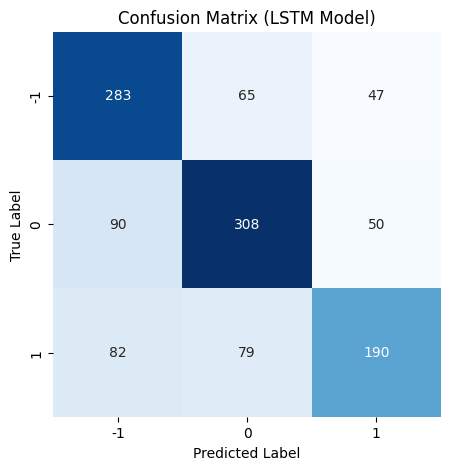

In [54]:
# Menghitung confusion matrix untuk kedua model
cm_lstm = confusion_matrix(y_true, y_pred_lstm)

# Fungsi untuk visualisasi confusion matrix
def plot_cm(cm, title):
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(title)
    plt.xticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.yticks([0.5, 1.5, 2.5], ['-1', '0', '1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Menampilkan visualisasi confusion matrix untuk kedua model
plot_cm(cm_lstm, "Confusion Matrix (LSTM Model)")

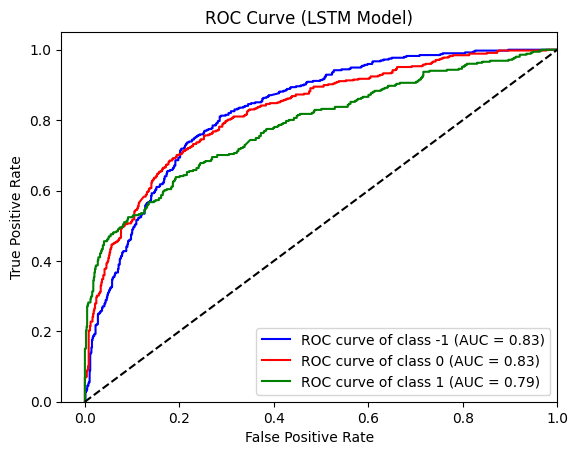

In [55]:
# Fungsi untuk menggambarkan ROC curve
def plot_roc_curve(y_true, y_score, n_classes, title):
    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=[-1, 0, 1])

    # Menghitung ROC curve dan AUC untuk setiap kelas
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Menggambarkan ROC curve
    plt.figure()
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color,
                 label='ROC curve of class {0} (AUC = {1:0.2f})'
                 ''.format(i-1, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

# Menggambarkan ROC curve untuk kedua model
plot_roc_curve(y_true, yhat_lstm, n_classes=3, title='ROC Curve (LSTM Model)')

Output

In [57]:
# Panggil dataset
full_data = pd.read_csv('../../Data/4. EDA/clean-eda.csv')

# Prediksi pada keseluruhan data
sequences_full = tokenizer.texts_to_sequences(full_data['text_manual_replaced'])
x_full_seq = pad_sequences(sequences_full, maxlen=max_len)
yhat_full_lstm = best_model.predict(x_full_seq)

# Konversi prediksi ke label kelas
yhat_full_lstm_classes = np.argmax(yhat_full_lstm, axis=1) - 1

# Tambahkan kolom baru ke DataFrame
full_data['predicted_sentiment'] = yhat_full_lstm_classes

full_data.head(10)

150/150 [==============================] - 33s 219ms/step


,video_id,comment_text,text_cleaned,text_removal,text_normalized,text_manual_replaced,text_tokenize,label,predicted_sentiment
0,video1,Baiknya bagaimana menurut kalian?,baiknya bagaimana menurut kalian,baik bagaimana turut kalian,baik bagaimana turut kalian,baik bagaimana turut kalian,"['baik', 'bagaimana', 'turut', 'kalian']",0,0
1,video1,Betul dok betul dok,betul dok betul dok,betul dok betul dok,betul dok betul dok,betul dok betul dok,"['betul', 'dok', 'betul', 'dok']",0,0
2,video1,Betul dok mungkin efek sa di,betul dok mungkin efek sa di,betul dok mungkin efek sa,betul dok mungkin efek sa,betul dok mungkin efek sa,"['betul', 'dok', 'mungkin', 'efek', 'sa']",0,0
3,video1,"Bpom aneh, tidak kerja. Kenapa ko seperti itu.",bpom aneh tidak kerja kenapa ko seperti itu,bpom aneh kerja ko itu,bpom aneh kerja kok itu,bpom aneh kerja kok itu,"['bpom', 'aneh', 'kerja', 'kok', 'itu']",-1,-1
4,video1,Benar banget anak sy aj hrs sirup minum obatny...,benar banget anak sy aj hrs sirup minum obatny...,benar banget anak sy aj hrs sirup minum obat d...,benar banget anak saya saja harus sirup minum ...,benar banget anak aku saja harus sirup minum o...,"['benar', 'banget', 'anak', 'aku', 'saja', 'ha...",0,0
5,video1,Makasih ilmunya dokter semoga berkah🥰🥰🥰🥰,makasih ilmunya dokter semoga berkah,makasih ilmu dokter moga berkah,terima kasih ilmu dokter moga berkah,terima kasih ilmu dokter semoga berkah,"['terima', 'kasih', 'ilmu', 'dokter', 'semoga'...",1,1
6,video1,Dok tempra gimana? Soalnya anakku kalau demam ...,dok tempra gimana soalnya anakku kalau demam d...,dok tempra gimana soal anak kalau demam kasih ...,dok tempra bagaimana soal anak kalau demam kas...,dok tempra bagaimana soal anak kalau demam kas...,"['dok', 'tempra', 'bagaimana', 'soal', 'anak',...",0,0
7,video1,BIOSOLFON KIDS AMAN GAK KAK,biosolfon kids aman gak kak,biosolfon kids aman gak kak,biosolfon kids aman enggak kak,biosolfon kids aman enggak kak,"['biosolfon', 'kids', 'aman', 'enggak', 'kak']",-1,0
8,video1,apa kurang ilmu ya dok,apa kurang ilmu ya dok,apa kurang ilmu dok,apa kurang ilmu dok,apa kurang ilmu dok,"['apa', 'kurang', 'ilmu', 'dok']",0,0
9,video1,Cara media massa cari uang.... Memainkan keres...,cara media massa cari uang memainkan keresahan...,cara media massa cari uang main resah bingung ...,cara media massa cari uang main resah bingung ...,cara media massa cari uang main resah bingung ...,"['cara', 'media', 'massa', 'cari', 'uang', 'ma...",-1,-1


In [ ]:
#full_data.to_csv("./../../Data/6. Prediksi/submission-LSTM.csv", index=False)